<h1 align="center" style=font-size:50px>Bank Customer Churn Prediction</h1>
<h3 align="center" style=font-size:30px>Modelagem</h3>
<h6 align="center" style=font-size:20px>Nessa etapa, vai ser desenvolvido um modelo de machine learning para prever se um cliente do banco vai dar churn ou não.</h6>

In [152]:
# importando as bibliotecas
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score, roc_auc_score, f1_score,confusion_matrix,average_precision_score
from sklearn.preprocessing import MinMaxScaler, TargetEncoder, OneHotEncoder,MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Funções 
# função que faz o preprocessamento
def preprocessor_pipeline(model) -> Pipeline:
    categorical_features_binary = ['Gender']
    categorical_features_non_binary = ['Geography','NumOfProducts']
    numerical_features = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']

    categorical_features_binary_transform = Pipeline(steps=[('ohe',OneHotEncoder()),
                                                            ('scaler',MaxAbsScaler())])
    categorical_features_non_binary_transform = Pipeline(steps=[('target_encoder',TargetEncoder()),
                                                            ('scaler',MaxAbsScaler())])
    numerical_features_transform = MinMaxScaler()

    preprocessor = ColumnTransformer(transformers=[('cat_binary',categorical_features_binary_transform,categorical_features_binary),
                                                    ('cat_non_binary',categorical_features_non_binary_transform,categorical_features_non_binary),
                                                    ('num',numerical_features_transform,numerical_features)])
    
    model_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                            ('model',model)])

    return model_pipeline

# Função que plota a matrix de confusão
def plot_cunfusion_matrix(y_test: pd.Series, y_pred: np.array) -> px.Figure:
    cm = confusion_matrix(y_test,y_pred)
    names = ['True Negative','False Positive','False Negative','True Positive']
    counts = [num for num in cm.flatten()]
    percents = [f'{num:.2%}' for num in cm.flatten()/np.sum(cm)]
    labels = [f'{value_1}\n{value_2}\n{value_3}' for value_1,value_2,value_3 in zip(names,counts,percents)]
    labels = np.asarray(labels).reshape(2,2)
    fig = px.imshow(cm,x=['0','1'],y=['0','1'],color_continuous_scale='greens')
    fig.update_traces(text=labels,texttemplate='%{text}',textfont = dict(size=12,family='Rockwell'))
    fig.update_layout(title = dict(text='<b>Confusion Matrix</b>',font_family='RockWell',font_size=30,font_color='black'),width=500)
    figure = fig
    return figure

# Função para avaliar o modelo
def avalaibe_model(model: Pipeline,X_train: pd.DataFrame,X_test: pd.DataFrame,y_train: pd.Series, y_test: pd.Series) -> tuple[pd.DataFrame,px.Figure]:

    model.fit(X_train,y_train)
    stratified_fold = StratifiedKFold(n_splits=5,shuffle=True)
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=stratified_fold, scoring='roc_auc',n_jobs=-1).mean()
    y_pred = model.predict(X_test)
   
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test,y_pred)
    
    recall = recall_score(y_test,y_pred)
    
    roc_auc = roc_auc_score(y_test,y_pred_proba[:,1])
    
    precision = precision_score(y_test,y_pred)
    avg_precision = average_precision_score(y_test,y_pred_proba[:,1])
    f1_sr = f1_score(y_test,y_pred)
    df_metrics = pd.DataFrame(data=[[accuracy,recall,roc_auc,precision,avg_precision,cv_score,f1_sr]],columns=['Accuracy','Recall','ROC AUC','Precision',
                                                                                                'Avg Precision','Cross Validation Score','F1-Score'],
                                                                                                index=['Scores'])
    df_metrics = df_metrics.map(lambda x: f'{x:.2%}')


    figure = plot_cunfusion_matrix(y_test,y_pred)
    

    return df_metrics.T,figure

In [153]:
# carregando o dataset
df = pd.read_csv('../data/df_cleaned.csv')
df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [154]:
# Separando as features e a response variable
X = df.drop(['Surname','Exited'],axis=1)
y = df['Exited']

In [155]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=24)

##################################################
Logistic Regression


,Scores
Accuracy,75.70%
Recall,69.98%
ROC AUC,81.13%
Precision,44.39%
Avg Precision,56.96%
Cross Validation Score,82.24%
F1-Score,54.32%


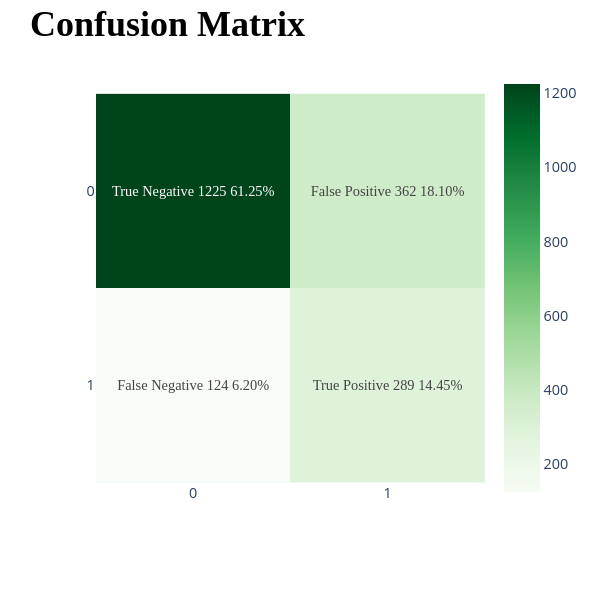

##################################################
Decision Tree Classifier


,Scores
Accuracy,78.20%
Recall,61.26%
ROC AUC,77.75%
Precision,47.83%
Avg Precision,41.38%
Cross Validation Score,77.14%
F1-Score,53.72%


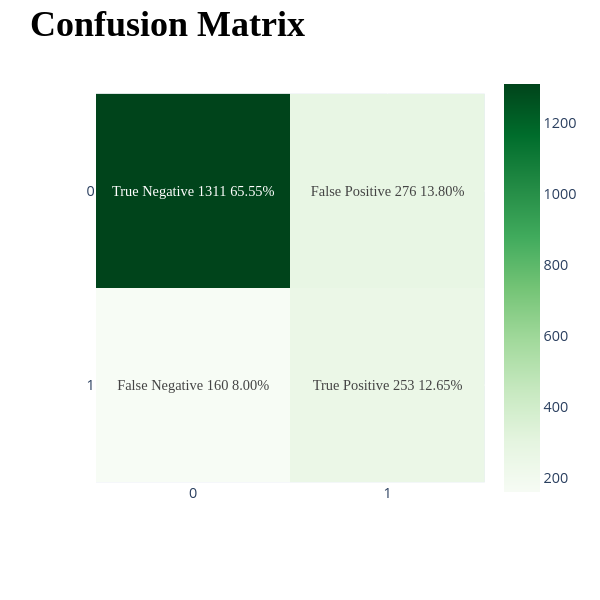

##################################################
XGBoost Classifier


,Scores
Accuracy,76.55%
Recall,68.77%
ROC AUC,83.48%
Precision,45.51%
Avg Precision,63.91%
Cross Validation Score,82.31%
F1-Score,54.77%


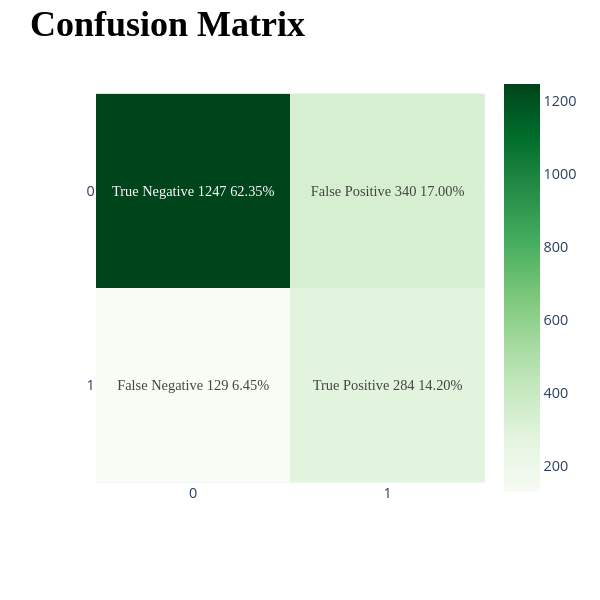

##################################################
Random Forest Classifier


,Scores
Accuracy,79.20%
Recall,72.88%
ROC AUC,84.11%
Precision,49.75%
Avg Precision,63.25%
Cross Validation Score,84.94%
F1-Score,59.14%


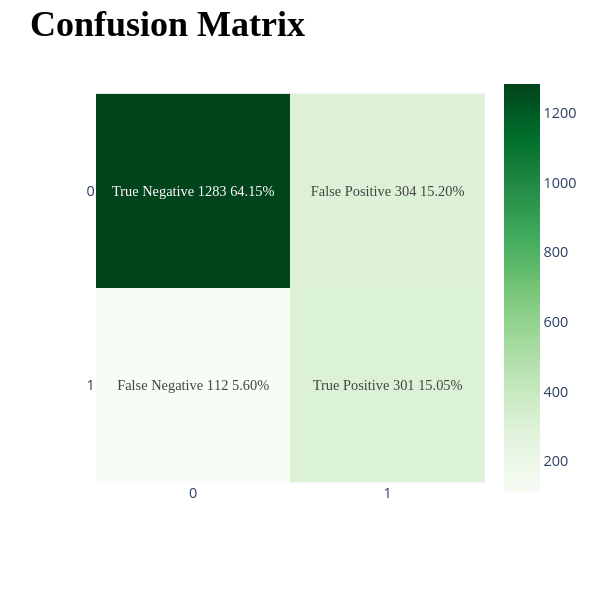

In [159]:
dict_models = {
    'Logistic Regression': LogisticRegression(penalty='l1',solver='liblinear',max_iter=1000,class_weight={0:0.2037,1:0.7963}),
    'Decision Tree Classifier': DecisionTreeClassifier(criterion='gini',max_depth=2,class_weight={0:0.2037,1:0.7963}),
    'XGBoost Classifier': XGBClassifier(n_estimators = 1000, max_depth = 2,scale_pos_weight=3.92),
    'Random Forest Classifier': RandomForestClassifier(n_estimators = 1000, max_depth = 7,class_weight={0:0.2037,1:0.7963}),
}
for name, model in dict_models.items():
    print('#'*50)
    print(name)
    metrics,figure = avalaibe_model(preprocessor_pipeline(model),X_train,X_test,y_train, y_test)
    display(metrics)
    figure.show('png',scale=1.2,width=500,height=500)

Como pode ser observado, o modelo que teve a melhor performance foi o Random Forest Classifier

## Conclusão
O objetivo desse projeto, era desenvolver uma solução usando machine learning para prever se um cliente do banco vai dar churn ou não. O modelo que desempenhou a melhor performance foi o Random Forest Classifier.